每隔30秒做一次检测，输入transformer的序列为每一秒内各个频段的脉冲次数。但是SNN很慢，仿真一个30秒需要3分钟多
参数：   
```
    parser.add_argument('--data_path', default='data\spike\snn_spike.json')
    parser.add_argument('--hidden_layer_dim', type=int, default=512)
    parser.add_argument('--num_layers', type=int, default=8)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--i_save', type=int, default=10)
    parser.add_argument('--output_path', default='./output/')
    optimizer = torch.optim.SGD(net.parameters(), lr=args.lr,momentum=0.1,weight_decay=0.01)
    lr_shedular = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, args.epochs+30)
```

In [18]:
from utils import load_data,filter,weights
import matplotlib.pyplot as plt
import numpy as np
import brian2 as b2
import SNN

In [6]:
import json

with open('data\\spike\\snn_spike.json') as f:
    data = json.load(f)
print(len(data.keys()))

140


<StemContainer object of 3 artists>

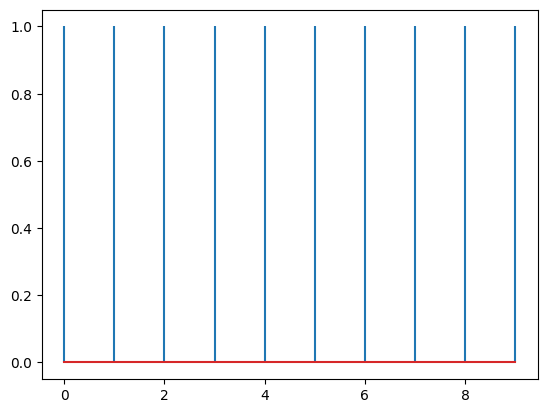

In [11]:
x = np.arange(0,10)
y = np.ones_like(x)
plt.stem(x,y,markerfmt=" ")

In [19]:
data,time,annotation = load_data.load_data('data\\edf_data\\SC4001E0-PSG.edf','data/csv_data/SC4001E0-PSG_annotations.csv','EEG Pz-Oz')
data = data[0:3000]
print(time)

Extracting EDF parameters from d:\work2\SNN\SleepStageClassify\data\edf_data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[      0   12000   51000   54000   57000   72000   75000   81000   87000
   90000  102000  105000  117000  120000  126000  132000  144000  147000
  150000  162000  183000  186000  192000  204000  207000  222000  228000
  231000  234000  237000  249000  264000  267000  270000  276000  279000
  288000  477000  480000  501000  507000  516000  531000  534000  621000
  639000  663000  666000  678000  687000  690000  783000  786000  789000
  795000  798000  801000  804000  807000  810000  813000  828000  834000
  843000  849000  852000  855000  861000  867000  885000  891000  894000
  897000  924000  927000  933000  936000  957000  960000  966000  969000
  987000 1074000 1077000 1083000 1086000 1098000 1185000 1188000 1191000
 1194000 1

In [20]:
band = filter.get_eeg_band(data)


In [21]:
def spike(data, interpolation_factor=35_000, refractory_period=3e-4):
    time = np.arange(0, data.shape[0])*0.01
    threshold = np.ceil(SNN.find_thresholds(
        data, time, window_size=0.5, sample_ratio=1/6, scaling_factor=0.3))
    spike_up, spike_dn = SNN.signal_to_spike(
        data, time, threshold, threshold, interpolation_factor=interpolation_factor, refractory_period=refractory_period)
    x = np.zeros_like(data)
    for i in spike_up:
        x[int(i*100)] = 1
    for i in spike_dn:
        x[int(i*100)] = -1
    return x

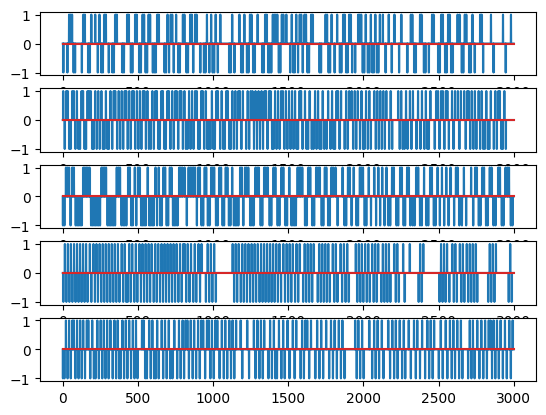

In [23]:
for i,key in enumerate(band.keys()):
    plt.subplot(5,1,i+1)
    plt.stem(spike(band[key],interpolation_factor=100,refractory_period=1e-1),markerfmt='')

In [24]:
def spike(data, interpolation_factor=35_000, refractory_period=3e-4):
    time = np.arange(0, data.shape[0])*0.01
    threshold = np.ceil(SNN.find_thresholds(
        data, time, window_size=0.5, sample_ratio=1/6, scaling_factor=0.3))
    spike_up, spike_dn = SNN.signal_to_spike(
        data, time, threshold, threshold, interpolation_factor=interpolation_factor, refractory_period=refractory_period)
    return spike_up,spike_dn

In [25]:
spike_up,spike_dn = spike(band['delta'])

In [27]:
compoent = SNN.snn(tau=0.1,args=)
net = b2.Network()
for key in compoent.keys():
    net.add(compoent[key])

mon = []
mon.append(b2.SpikeMonitor(compoent['input']))
mon.append(b2.SpikeMonitor(compoent['neu_output']))
mon.append(b2.SpikeMonitor(compoent['neu_hidden']))
mon.append(b2.StateMonitor(compoent['neu_output'],'v',record=0))
for i in mon:
    net.add(i)

TypeError: snn() missing 1 required positional argument: 'args'

In [8]:
net.run(30*b2.second)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]


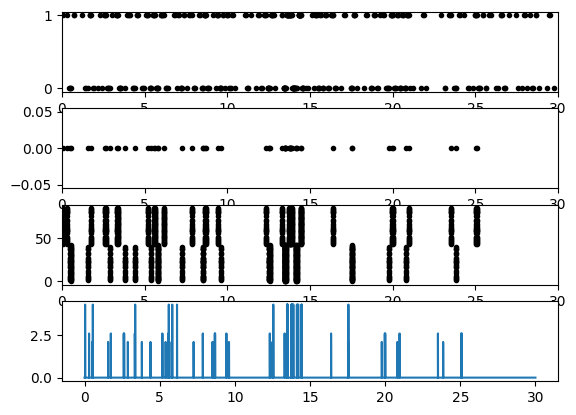

In [9]:
for i in range(3):
    plt.subplot(4,1,i+1)
    plt.plot(mon[i].t/b2.second,mon[i].i,'.k')
    plt.xlim([0,30])
plt.subplot(4,1,4)
plt.plot(mon[3].t/b2.second,mon[3].v[0],'-')